In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
#gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
sparcfire_matched = Table.read('fits/galaxy_level_matched.fits')
mendel_matched = Table.read('fits/mendel_matched.fits')
ml_table_matched = Table.read('fits/ml_table_matched.fits')
gz2_stats = Table.read('fits/gz2_statistics.fits')
mass_masks = Table.read('fits/mass_masks_matched.fits')

In [4]:
in_ml = ml_table_matched['vmax_ok']
in_sparcfire = sparcfire_matched['P_wtd_avg'] >= 0
ml_sparcfire = np.all([in_ml,in_sparcfire],axis=0)

mendel_matched['BTR'] = ((10**(mendel_matched['logMb'])/
                        (10**mendel_matched['bulge+disc'])))

unbarred = gz2_stats['p_bar'] <= 0.5
ml_unbarred = np.all([in_ml,unbarred],axis=0)
ml_sparcfire_unbarred = np.all([ml_sparcfire,unbarred],axis=0)

print('{} unbarred galaxies; {} in sparcfire'.format(ml_unbarred.sum(),
                                                ml_sparcfire_unbarred.sum()))

4095 unbarred galaxies; 2019 in sparcfire


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


In [5]:
'''
bulge_classes = ['t05_bulge_prominence_a10_no_bulge_debiased_rh',
                 't05_bulge_prominence_a11_just_noticeable_debiased_rh',
                 't05_bulge_prominence_a12_obvious_debiased_rh',
                 't05_bulge_prominence_a13_dominant_debiased_rh']

bulge_array = np.array([gz2_data[c] for c in bulge_classes]).T

B = np.argmax(bulge_array,axis=1) + 1
B_wtd_avg = np.zeros(len(gz2_data))

for b, bulge_column in enumerate(bulge_classes):
    B_wtd_avg += (b+1)*gz2_data[bulge_column]
    
B_wtd_avg[np.isfinite(B_wtd_avg) == False] = 0
'''

"\nbulge_classes = ['t05_bulge_prominence_a10_no_bulge_debiased_rh',\n                 't05_bulge_prominence_a11_just_noticeable_debiased_rh',\n                 't05_bulge_prominence_a12_obvious_debiased_rh',\n                 't05_bulge_prominence_a13_dominant_debiased_rh']\n\nbulge_array = np.array([gz2_data[c] for c in bulge_classes]).T\n\nB = np.argmax(bulge_array,axis=1) + 1\nB_wtd_avg = np.zeros(len(gz2_data))\n\nfor b, bulge_column in enumerate(bulge_classes):\n    B_wtd_avg += (b+1)*gz2_data[bulge_column]\n    \nB_wtd_avg[np.isfinite(B_wtd_avg) == False] = 0\n"

In [6]:
import xy_plots
import imp
imp.reload(xy_plots)
from xy_plots import x_vs_y

def bulge_disc_plotter(mass_table,y,weights=None,figaxarr=None,
                       error_kwargs={'alpha':0.2},
                       line_kwargs={'linewidth':2},label=None):
    if figaxarr is None:
        fig, axarr = plt.subplots(1,4,figsize=(20,5.5),sharey=True)
        fig.subplots_adjust(hspace=0,wspace=0)
    else:
        fig, axarr = figaxarr
        
    xs = [mass_table[c] for c in ['logMb','logMd','bulge+disc','BTR']]
    for ax, x in zip(axarr,xs):
        xy = x_vs_y(x,y,weights)
        xy.continuous_vs_continuous_binned(equal_N=True,bins=8)
        r, p = xy.spearmanr(ax,plot=False,printout=False)
        if label is not None:
            axlabel = label + ' ($N_\mathrm{{gal}}={}$, {}, {})'.format(len(x),r,p)
        xy.line_plot(ax,label=axlabel,**line_kwargs)
        xy.error_plot(ax,**error_kwargs)
    
    return fig, axarr

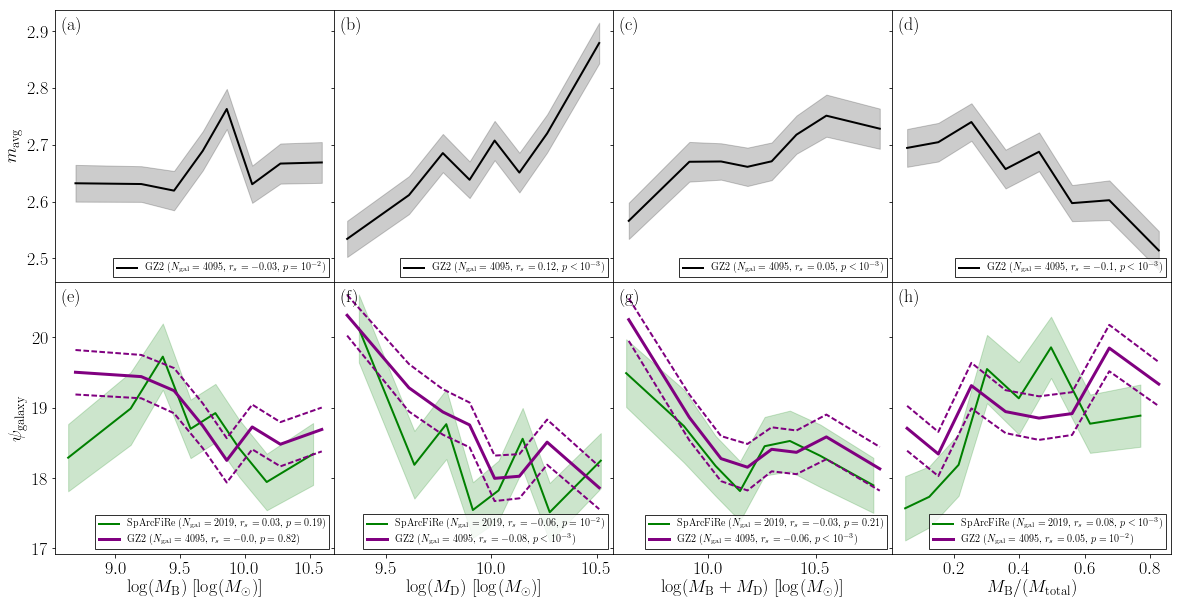

In [21]:
import warnings
warnings.filterwarnings('ignore')

fig, axarr = plt.subplots(2,4,figsize=(20,10),
                          sharex='col',sharey='row')

fig.subplots_adjust(hspace=0,wspace=0)

axarr = axarr.ravel()
letters = 'abcdefghijklmnopqrstuvwxyz'
for ax, letter in zip(axarr,letters):
    ax.text(0.025,0.975,'({})'.format(letter),
           transform=ax.transAxes,ha='left',va='top')
    
xlabels = ('$\log(M_\mathrm{B})$ [$\log(M_\odot)$]',
           '$\log(M_\mathrm{D})$ [$\log(M_\odot)$]',
           '$\log(M_\mathrm{B}+M_\mathrm{D})$ [$\log(M_\odot)$]',
           '$M_\mathrm{B}/(M_\mathrm{total})$')

for ax, xlabel in zip(axarr[-4:],xlabels):
    ax.set_xlabel(xlabel)
    
_ = axarr[0].set_ylabel('$m_\mathrm{avg}$')
_ = axarr[4].set_ylabel('$\psi_\mathrm{galaxy}$')


#------------------------------------------------
x_ = mendel_matched[ml_unbarred]
y_ = gz2_stats['m_wtd_avg'][ml_unbarred]
w_ = ml_table_matched['vmax_weight'][ml_unbarred]

_ = bulge_disc_plotter(x_,y_,w_,figaxarr=(fig,axarr[:4]),
                       error_kwargs={'style':'filled',
                                     'color':'k',
                                     'alpha':0.2},
                        line_kwargs={'linewidth':2,
                                     'color':'k'},
                        label='GZ2')

#------------------------------------------------
x_ = mendel_matched[ml_sparcfire_unbarred]
y_ = sparcfire_matched['P_wtd_avg'][ml_sparcfire_unbarred]
w_ = ml_table_matched['vmax_weight'][ml_sparcfire_unbarred]

_ = bulge_disc_plotter(x_,y_,w_,figaxarr=(fig,axarr[4:]),
                       error_kwargs={'style':'filled',
                                     'color':'green',
                                     'alpha':0.2},
                        line_kwargs={'linewidth':2,
                                     'color':'green'},
                        label='SpArcFiRe')

#------------------------------------------------
x_ = mendel_matched[ml_unbarred]
y_ = gz2_stats['psi_gz2+error'][ml_unbarred]
w_ = ml_table_matched['vmax_weight'][ml_unbarred]
_ = bulge_disc_plotter(x_,y_,w_,figaxarr=(fig,axarr[4:]),
                       error_kwargs={'style':'lined',
                                     'color':'purple',
                                     'linewidth':2,
                                     'linestyle':'dashed'},
                        line_kwargs={'linewidth':3,
                                     'color':'purple'},
                        label='GZ2')

for ax in axarr:
    ax.legend(loc='lower right',fontsize=10,fancybox=False,edgecolor='k')
    
fig.savefig('paper_figures/bulge_disc.pdf')

#### Now, make similar plots using the GZ2 derived characteristics:

- logM_B vs. psi
- logM_B vs. psi (GZ2)
- B_wtd_avg vs. psi
- B_wtd_avg vs. psi (GZ2)

In [ ]:
'''
fig, axarr = plt.subplots(2,2,figsize=(10,10),
                          sharex='col',sharey='row')
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0,wspace=0)

x_s = [mendel_matched['logMb'], B_wtd_avg, 
       mendel_matched['logMb'], B_wtd_avg]

y_s = [sparcfire_matched['P_wtd_avg'],sparcfire_matched['P_wtd_avg'],
       gz2_stats['w_wtd_avg'],gz2_stats['w_wtd_avg']]

masks = [ml_sparcfire_unbarred,ml_sparcfire_unbarred,
         ml_unbarred,ml_unbarred]

weights = ml_table_matched['vmax_weight']

for x_, y_, mask, ax in zip(x_s,y_s,masks,axarr):
    
    xy = x_vs_y(x_[mask],y_[mask],weights[mask])
    xy = xy.continuous_vs_continuous_binned(equal_N=True,bins=10)
    xy.line_plot(ax,color='k',lw=3)
    xy.error_plot(ax,color='k',style='lined',lw=1,linestyle='dashed')
    xy.spearmanr(ax,location='upper left')
    #xy.scatter(ax)
    
_ = axarr[2].set_xlabel('$\log(M_\mathrm{B})$ [Mendel+14]')
_ = axarr[3].set_xlabel('$w_\mathrm{wtd \, avg}$ [GZ2]')
_ = axarr[0].set_ylabel(r'$\psi_\mathrm{galaxy}$ [SpArcFiRe]')
_ = axarr[2].set_ylabel('$B_\mathrm{wtd \, avg}$ [GZ2]')
'''

#### Final plot for now: SFR vs. spiral ar number + spiral arm pitch angle

In [12]:
sfrs = Table.read('../fits/SF_fits/sfrs+ids.fits')
galaxy_level_matched = Table.read('fits/galaxy_level_matched.fits')

In [13]:
def sfr_plotter(x,sfr_table,figaxarr=None,
                error_kwargs={'alpha':0.2},
                line_kwargs={'linewidth':2},label=None):
    
    if figaxarr is None:
        fig, axarr = plt.subplots(1,4,figsize=(20,5.5),sharey=True)
        fig.subplots_adjust(hspace=0,wspace=0)
    else:
        fig, axarr = figaxarr
    
    ok_F = sfr_table['F'] >= 2
    ok_w4 = sfr_table['w4'] >= 2
    ok_mpa = sfr_table['sfr_mpa'] >= -3
    ok_both = np.all([ok_F,ok_w4],axis=0)
    masks = [ok_F,ok_w4,ok_both,ok_both]
    columns = ['sfr_fuv','sfr_22','sfr_total','mir_fraction']
    
    for ax, mask, column in zip(axarr,masks,columns):
        x_ = x[mask]
        y_ = sfr_table[column][mask]
        xy = x_vs_y(x_,y_)
        xy = xy.continuous_vs_continuous_binned(equal_N=True,bins=8)
        r, p = xy.spearmanr(ax,plot=False,printout=False)
        if label is not None:
            axlabel = label + ' ($N_\mathrm{{gal}}={}$, {}, {})'.format(len(x),r,p)
        xy.line_plot(ax,label=axlabel,**line_kwargs)
        xy.error_plot(ax,**error_kwargs)
    
    return fig, axarr

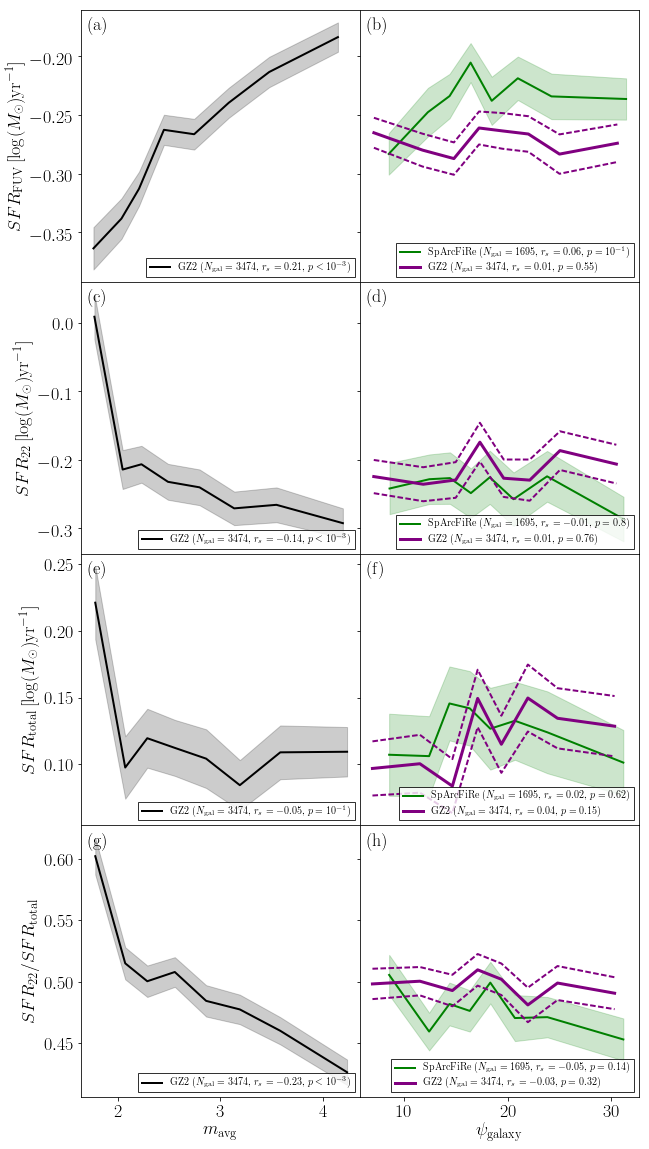

In [22]:
fig, axarr = plt.subplots(4,2,figsize=(10,20),
                          sharex='col',sharey='row')

fig.subplots_adjust(hspace=0,wspace=0)

ylabels = ('$SFR_\mathrm{FUV} \,[\log(M_\odot) \mathrm{yr}^{-1}]$',
           '$SFR_\mathrm{22} \, [\log(M_\odot) \mathrm{yr}^{-1}]$',
           '$SFR_\mathrm{total} \, [\log(M_\odot) \mathrm{yr}^{-1}]$',
           '$SFR_\mathrm{22}/SFR_\mathrm{total}$')

for ax, ylabel in zip(axarr[:,0],ylabels):
    ax.set_ylabel(ylabel)

axarr[-1,0].set_xlabel('$m_\mathrm{avg}$')
axarr[-1,1].set_xlabel('$\psi_\mathrm{galaxy}$')
#axarr[-1,2].set_xlabel('$\psi_\mathrm{galaxy,GZ2}$')

#------------------------------------------------
mass_matched_masks = []

for m in ('1','2','3','4','5+'):
    mass_matched_masks.append(mass_masks['m={}, b=1'.format(m)])
    mass_matched_masks.append(mass_masks['m={}, b=2'.format(m)])
#mass_matched_masks.append(in_ml)
in_mass_match = np.any(mass_matched_masks,axis=0)
in_mm_sample = np.all([in_mass_match,in_ml],axis=0)
in_mm_sparcfire = np.all([in_mm_sample,in_sparcfire],axis=0)

#------------------------------------------------
x_ = gz2_stats['m_wtd_avg'][in_mm_sample]
y_ = sfrs[in_mm_sample]

_ = sfr_plotter(x_,y_,figaxarr=(fig,axarr[:,0]),
                error_kwargs={'style':'filled','color':'k',
                              'alpha':0.2},
                line_kwargs={'linewidth':2,'color':'k'},
                label='GZ2')
#------------------------------------------------
x_ = galaxy_level_matched['P_wtd_avg'][in_mm_sparcfire]
y_ = sfrs[in_mm_sparcfire]

_ = sfr_plotter(x_,y_,figaxarr=(fig,axarr[:,1]),
                error_kwargs={'style':'filled',
                              'color':'green',
                              'alpha':0.2},
                line_kwargs={'linewidth':2,
                             'color':'green'},
               label='SpArcFiRe')


##################
x_ = gz2_stats['psi_gz2+error'][in_mm_sample]
y_ = sfrs[in_mm_sample]

_ = sfr_plotter(x_,y_,figaxarr=(fig,axarr[:,1]),
                error_kwargs={'style':'lined',
                              'color':'purple',
                              'linewidth':2,
                              'linestyle':'dashed'},
                line_kwargs={'linewidth':3,
                             'color':'purple'},
                label='GZ2')
#------------------------------------------------

axarr = axarr.ravel()
letters = 'abcdefghijklmnopqrstuvwxyz'
for ax, letter in zip(axarr,letters):
    ax.text(0.025,0.975,'({})'.format(letter),
           transform=ax.transAxes,ha='left',va='top')
    
for ax in axarr:
    ax.legend(loc='lower right',fancybox=False,
              edgecolor='k',fontsize=10)
    
fig.savefig('paper_figures/sfrs.pdf')